## Рекомендательная система

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [235]:
# читаем файлы
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
train = data_train.copy()
test = data_test.copy()

C:\apps\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\apps\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1 EDA

In [236]:
# посмотрим, что вообще представляет из себя датасет
print('train.shape = ', train.shape)
train.head(5)

train.shape =  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [127]:
# посмотрим на типы данных и количество пропущенных значений
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


Есть немного пропусков в поле *reviewerName*. Cкорее всего, это никак не должно влиять на остальные данные. Посмотрим, как выглядят данные с пропущенными *reviewerName*. Видим, что в остальном данные выглядят ок, поэтому просто удалим этот столбец и будем идентифицировать пользователья только по *userid*. Дополнительно убедимся в этом, посмотрев на распределениe первоначальной оценки *overall* и разброс времени оставления отзывов для клиентов с наличием *reviewerName* и его отсутствием.

In [237]:
train[train.reviewerName.isna()].sample(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
179321,1.0,True,"05 4, 2018",B000H1CO74,NaN,"Awful; not as good as reduced sugar, and eith ...",Yuck,1525392000,NaN,"{'Size:': ' 13 Ounce', 'Flavor:': ' Reduced Su...",NaN,103223,2466,0.0
308465,5.0,False,"08 29, 2011",B000LKU16C,NaN,I was so shocked to find out that almost all g...,These are the best mints and no aspartame or BHT,1314576000,NaN,"{'Size:': ' 1.76 Ounce (Pack of 6)', 'Flavor:'...",NaN,10625,3190,1.0
486237,5.0,True,"03 4, 2016",B00N0X0TF0,NaN,Thanks so much!,Five Stars,1457049600,NaN,NaN,NaN,24268,30387,1.0


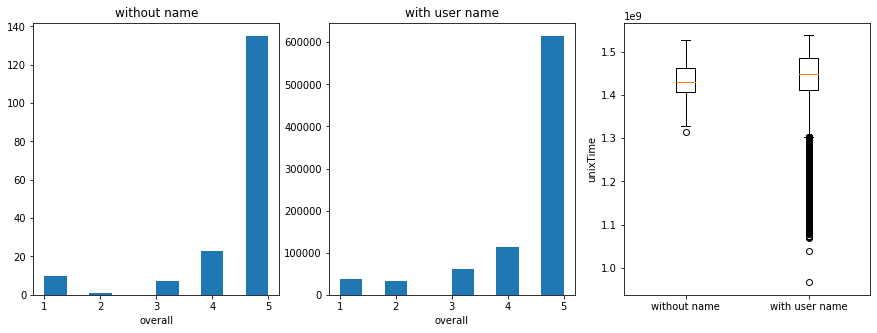

In [129]:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
axes[0].set_title('without name')
axes[0].set_xlabel('overall')
axes[1].set_xlabel('overall')
axes[1].set_title('with user name')
axes[0].hist(train[train.reviewerName.isna() == True].overall)
axes[1].hist(train[train.reviewerName.isna() == False].overall)
axes[2].set_ylabel('unixTime')
axes[2].boxplot([train[train.reviewerName.isna()].unixReviewTime, train[train.reviewerName.isna() == False].unixReviewTime],
               labels=['without name', 'with user name'])
plt.show()

In [238]:
# удалим колонку reviewerName из тренировочного датасета
train.drop('reviewerName', axis = 1, inplace = True)
train

,overall,verified,reviewTime,asin,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.0,True,"04 2, 2013",B000H7ELTW,Next to the round variety hanging on my cherry...,next to the round variety............,1364860800,NaN,{'Flavor:': ' Dried Cherries'},NaN,59433,2566,1.0
857891,2.0,True,"12 13, 2015",B0012NI02O,Not my cup of tea.,Two Stars,1449964800,NaN,{'Package Quantity:': ' 1'},NaN,86473,5828,0.0
857892,4.0,False,"09 21, 2016",B000LKX6R8,"I really like these noodles, I just gave it on...",good but better value elsewhere,1474416000,NaN,{'Size:': ' Pack of 8'},NaN,88,3251,1.0
857893,4.0,True,"11 1, 2015",B00BUKL666,"I like these, they are the kind for a snack an...",Great selection,1446336000,NaN,NaN,NaN,41540,22208,1.0


In [239]:
# переведем дату в формат datetime. 
# Дублирующий столбец unixReviwTime удалать не будем, возможно с ним проще вычисления проводить
train.reviewTime = pd.to_datetime(train.reviewTime)



In [240]:
# стобец asin - будет нужен для формирования таблицы item_features

# определим длину отзыва в символах и посмотрим, влияет ли на оценку
train['lenRev'] = train['reviewText'].apply(lambda x: len(str(x)))
train['lenSum'] = train['summary'].apply(lambda x: len(str(x)))
train['vote'] = train.vote.apply(lambda x: str(x).replace(',',''))
train['vote'] = train['vote'].fillna('0').astype('float64')
train[['overall', 'lenRev', 'lenSum', 'vote']].corr()
# связи практически нет, эти столбцы не нужны
#   также нет связи между оценкой и количеством голосований за отзыв

,overall,lenRev,lenSum,vote
overall,1.000000,-0.098732,-0.091622,-0.005140
lenRev,-0.098732,1.000000,0.331831,0.220251
lenSum,-0.091622,0.331831,1.000000,0.045504
vote,-0.005140,0.220251,0.045504,1.000000


In [241]:
# удалим столбцы style и image
train.drop(['style', 'image'], axis=1, inplace=True)

## 2 Построим пробную модель из baseline

In [180]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

C:\apps\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [181]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [182]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [183]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [184]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [185]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7457838606983627

In [186]:
preds.max(), preds.min()

(27.039236068725586, -28.403818130493164)

In [187]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [189]:
normalized_preds.max(), normalized_preds.min()

(1.0, 0.0)

In [190]:
sklearn.metrics.roc_auc_score(test_data.rating,normalized_preds)

0.7457838606983627

In [196]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   overall     857895 non-null  float64       
 1   verified    857895 non-null  bool          
 2   reviewTime  857895 non-null  datetime64[ns]
 3   asin        857895 non-null  object        
 4   reviewText  857616 non-null  object        
 5   summary     857725 non-null  object        
 6   vote        118740 non-null  float64       
 7   userid      857895 non-null  int64         
 8   itemid      857895 non-null  int64         
 9   rating      857895 non-null  float64       
 10  lenRev      857895 non-null  int64         
 11  lenSum      857895 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 72.8+ MB


In [205]:
# обучим модель на полной тренировочной выборке и сделаем submission
rating_coo_full = sparse.coo_matrix((train['rating'].astype(int), 
                                    (train['userid'], train['itemid'])))
model_full = LightFM(learning_rate=0.1, loss='logistic',
                    no_components=NUM_COMPONENTS)
model_full = model_full.fit(rating_coo_full, epochs=NUM_EPOCHS,
                       num_threads=NUM_THREADS)
preds_kaggle = model_full.predict(test.userid.values,
                                 test.itemid.values)

In [206]:
preds_kaggle.min(), preds_kaggle.max()

(-30.373123168945312, 32.792266845703125)

In [245]:
#   нормализация предсказаний
preds_kaggle = (preds_kaggle - preds_kaggle.min())/(preds_kaggle.max() - preds_kaggle.min())

In [214]:
submission['rating'] = preds_kaggle
submission.to_csv('data/submission.csv', index=False)

## 3 Построим характеристики пользователей (user_features)

идеи для признаков пользователей:  
- средняя длина отзыва,  
- разброс по длине отзыва,  
- отзыв в выходные или нет,  
- среднее время между отзывами,
- разброс между отзывами,
- средние голоса за отзыв,
- разброс между голосами,

-Таргеты-  
- процент понравившися товаров (сумма единиц, деленная на количество отзывов),
- overall  
Вопрос: в LightFM можно добавить матрицы user_features и item_features. Колонки features должны быть одинаковые у них?

In [243]:
train['vote'].fillna(0, inplace=True)

In [244]:
users = train[['userid', 'overall', 'vote', 'unixReviewTime', 'lenRev']].groupby(by='userid').agg(['mean', 'std', 'count'])
users

overall                      vote                 unixReviewTime  \
            mean       std count      mean       std count           mean   
userid                                                                      
0       5.000000  0.000000     2  0.000000  0.000000     2   1.467288e+09   
1       4.533333  0.915475    15  0.200000  0.774597    15   1.420952e+09   
2       4.578947  1.017393    19  0.210526  0.630604    19   1.457695e+09   
3       4.571429  1.133893     7  0.000000  0.000000     7   1.432759e+09   
4       4.333333  1.632993     6  0.333333  0.816497     6   1.434067e+09   
...          ...       ...   ...       ...       ...   ...            ...   
127491  5.000000  0.000000     6  0.000000  0.000000     6   1.531440e+09   
127492  4.733333  0.798809    15  0.000000  0.000000    15   1.531820e+09   
127493  4.800000  0.447214     5  0.000000  0.000000     5   1.529366e+09   
127494  2.600000  1.516575     5  0.000000  0.000000     5   1.528762e+09   
127495  5.000000  0.000000     3  0.000000  0.000000     3   1.470269e+09   

                                lenRev                   
                 std count        mean        std count  
userid                                                   
0       7.202986e+07     2   49.500000  43.133514     2  
1       1.975359e+07    15  101.266667  79.352259    15  
2       3.409869e+07    19   90.210526  57.581420    19  
3       5.903204e+07     7  111.142857  90.666842     7  
4       5.051615e+07     6   91.833333  73.526639     6  
...              ...   ...         ...        ...   ...  
127491  0.000000e+00     6   58.166667  25.261961     6  
127492  1.075572e+06    15   15.866667   9.006876    15  
127493  0.000000e+00     5   95.800000  23.889328     5  
127494  0.000000e+00     5   44.400000  44.252684     5  
127495  0.000000e+00     3    7.000000   5.196152     3  

[127448 rows x 12 columns]

In [247]:
users.columns = ['overall_mean', 'overall_std', 'overall_count',
                 'vote_mean', 'vote_std', 'vote_count',
                 'unixReview_mean', 'unixReview_std', 'unixReview_count',
                 'lenRev_mean', 'lenRev_std', 'lenRev_count']

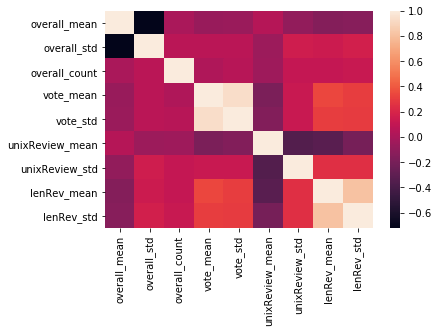

In [251]:
users.drop(['vote_count', 'unixReview_count', 'lenRev_count'], axis=1, inplace=True)
sns.heatmap(users.corr())
# не видно какой-то связи средней оценки и рассчитанных характеристик

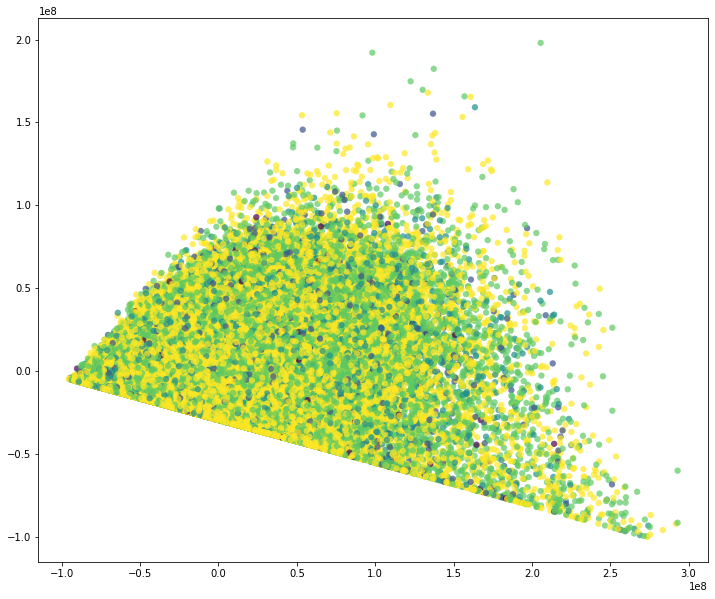

In [265]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
users_reduced = pca.fit_transform(users.fillna(0))
y = users.overall_mean.apply(round)

plt.figure(figsize=(12,10))
plt.scatter(users_reduced[:, 0], users_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40)
# тоже не видно ничего похожего на кластеры

Вывод: пока для юзеров ничего интересного не нашла

## 4 Построим характеристики продуктов (item_features)

In [266]:
# TODO: работа с большим файлом json

## 5 Базовая модель LightFM и попробовать настроить параметры

In [ ]:
# пока не получилось ничего полезного сделать с пользователями.
# попробуем настроить параметры модели
#    TODO: кроссвалидация? графически нарисовать зависимость от параметров? 


In [293]:
for NUM_COMPONENTS in  np.arange(10, 55, 5):
    for NUM_EPOCHS in np.arange(10, 110, 10):
        print(f'no_components: {NUM_COMPONENTS}, epochs: {NUM_EPOCHS}')
        model = LightFM(learning_rate=0.1, loss='logistic',
                        no_components=NUM_COMPONENTS)
        model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                          num_threads=NUM_THREADS)
        preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)
        print(f'ROC AUC: {sklearn.metrics.roc_auc_score(test_data.rating,preds)}')
        




no_components: 10, epochs: 10
ROC AUC: 0.7406619025707026
no_components: 10, epochs: 20
ROC AUC: 0.7335729654429729
no_components: 10, epochs: 30
ROC AUC: 0.7211128275165166
no_components: 10, epochs: 40
ROC AUC: 0.7139176482036043
no_components: 10, epochs: 50
ROC AUC: 0.7058482944872564
no_components: 10, epochs: 60
ROC AUC: 0.7013727306880808
no_components: 10, epochs: 70
ROC AUC: 0.7006792747924607
no_components: 10, epochs: 80
ROC AUC: 0.6948243620210817
no_components: 10, epochs: 90
ROC AUC: 0.6947126899273484
no_components: 10, epochs: 100
ROC AUC: 0.6943306461260245
no_components: 15, epochs: 10
ROC AUC: 0.7415087699218137
no_components: 15, epochs: 20
ROC AUC: 0.7364518383853557
no_components: 15, epochs: 30
ROC AUC: 0.7266868465365341
no_components: 15, epochs: 40
ROC AUC: 0.7176626377845847
no_components: 15, epochs: 50
ROC AUC: 0.7141725235483498
no_components: 15, epochs: 60
ROC AUC: 0.7104835339708266
no_components: 15, epochs: 70
ROC AUC: 0.7089705422161068
no_components

## 6 Сделать рекомендацию для какого-нибудь пользователя

In [294]:
# TODO